In [69]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

In [70]:
df = fdr.DataReader('005930','2020-03-01')
df.head()

Open   High    Low  Close    Volume    Change
Date                                                      
2020-03-02  54300  55500  53600  55000  30403412  0.014760
2020-03-03  56700  56900  55100  55400  30330295  0.007273
2020-03-04  54800  57600  54600  57400  24765728  0.036101
2020-03-05  57600  58000  56700  57800  21698990  0.006969
2020-03-06  56500  57200  56200  56500  18716656 -0.022491

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376 entries, 2020-03-02 to 2021-09-02
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    376 non-null    int64  
 1   High    376 non-null    int64  
 2   Low     376 non-null    int64  
 3   Close   376 non-null    int64  
 4   Volume  376 non-null    int64  
 5   Change  376 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 20.6 KB


In [72]:
df.drop(columns=['Open', 'High', 'Low', 'Volume','Change'], inplace=True)

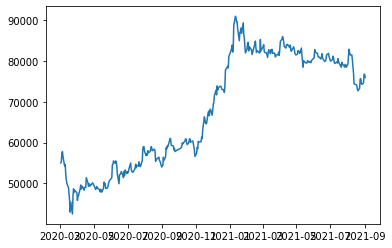

In [73]:
plt.plot(df)

In [74]:
close_data = df['Close'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df.index[:split]
date_test = df.index[split:]

print(len(close_train))
print(len(close_test))

300
76


In [75]:
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [76]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 50
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/25
15/15 [==============================] - 1s 9ms/step - loss: 4940698112.0000
Epoch 2/25
15/15 [==============================] - 0s 11ms/step - loss: 4667487232.0000
Epoch 3/25
15/15 [==============================] - 0s 9ms/step - loss: 4477439488.0000
Epoch 4/25
15/15 [==============================] - 0s 8ms/step - loss: 4322542592.0000
Epoch 5/25
15/15 [==============================] - 0s 10ms/step - loss: 4197367040.0000
Epoch 6/25
15/15 [==============================] - 0s 11ms/step - loss: 4076011264.0000
Epoch 7/25
15/15 [==============================] - 0s 11ms/step - loss: 3979132416.0000
Epoch 8/25
15/15 [==============================] - 0s 11ms/step - loss: 3869389824.0000
Epoch 9/25
15/15 [==============================] - 0s 10ms/step - loss: 3760738304.0000
Epoch 10/25
15/15 [==============================] - 0s 6ms/step - loss: 3644014336.0000
Epoch 11/25
15/15 [==============================] - 0s 6ms/step - loss: 3557538816.0000
Epoch 12/25
15/15 [=====

In [77]:
import plotly.graph_objects as go

In [78]:
prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "SS Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [79]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [80]:
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
trace4 = go.Scatter(
    x=forecast_dates,
    y=forecast,
    mode = 'lines',
    name = 'Forecast'
)
layout = go.Layout(
    title = "SS",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()